# Variational quantum autoencoder

Circuit ansatz from: https://arxiv.org/pdf/2010.06599.pdf

In [1]:
import time
import numpy as np
from scipy.optimize import minimize, basinhopping
from qiskit import *
from qiskit.quantum_info import Statevector
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B, SPSA
import matplotlib.pyplot as plt
%matplotlib inline

### Exact diagonalization 
In order to get ground state for input into quantum circuit

In [354]:
# from: https://tenpy.readthedocs.io/en/latest/toycodes/tfi_exact.html
import numpy as np
import scipy.sparse as sparse
import scipy.sparse.linalg.eigen.arpack as arp
import warnings
import scipy.integrate


def ising_groundstate(L, Jz, gx, gz=0): # g is transverse field, gx the longitudinal
    """For comparison: obtain ground state energy from exact diagonalization.

    Exponentially expensive in L, only works for small enough `L` <~ 20.
    """
    if L >= 20:
        warnings.warn("Large L: Exact diagonalization might take a long time!")
    # get single site operaors
    sx = sparse.csr_matrix(np.array([[0., 1.], [1., 0.]]))
    sz = sparse.csr_matrix(np.array([[1., 0.], [0., -1.]]))
    id = sparse.csr_matrix(np.eye(2))
    sx_list = []  # sx_list[i] = kron([id, id, ..., id, sx, id, .... id])
    sz_list = []
    for i_site in range(L):
        x_ops = [id] * L
        z_ops = [id] * L
        x_ops[i_site] = sx
        z_ops[i_site] = sz
        X = x_ops[0]
        Z = z_ops[0]
        for j in range(1, L):
            X = sparse.kron(X, x_ops[j], 'csr')
            Z = sparse.kron(Z, z_ops[j], 'csr')
        sx_list.append(X)
        sz_list.append(Z)
    H_zz = sparse.csr_matrix((2**L, 2**L))
    H_z = sparse.csr_matrix((2**L, 2**L))
    H_x = sparse.csr_matrix((2**L, 2**L))
    for i in range(L - 1):
        H_zz = H_zz + sz_list[i] * sz_list[(i + 1) % L]
    for i in range(L):
        H_z = H_z + sz_list[i]
        H_x = H_x + sx_list[i]
    H = -J * H_zz - gx * H_x - gz * H_z 
    E, V = arp.eigsh(H, k=1, which='SA', return_eigenvectors=True, ncv=20)
    return V[:,0], E[0]
init_state, E = ising_groundstate(6, 1., 1., 1.)

### Define variational quantum circuit
At the moment only works for 6 quibts (two of them are trash qubits).

Other ansatze that might be worth trying: PauliTwoDesign, RealAmplitudes, EfficientSU2

In [365]:
# Use Aer's qasm_simulator
backend_sim = Aer.get_backend('qasm_simulator')

L = 6 # system size
thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, (2*L+2, 2)) # initial parameters with feature encoding

In [356]:
def prepare_circuit(init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    entangler_map1 = [(5, 4), (5, 3), (5, 1), (4, 2), (4, 0)]
    entangler_map2 = [(5, 4), (5, 2), (4, 3), (5, 0), (4, 1)]
    circ += circuit.library.TwoLocal(L, 'ry', 'cz', entanglement = [entangler_map1, entangler_map2], reps=2, insert_barriers=True, skip_final_rotation_layer=True)
    circ.ry(circuit.Parameter('θ1'), 4)
    circ.ry(circuit.Parameter('θ2'), 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    if init_state is not None: circ.initialize(init_state, qreg)
    return circ

# same circuit as above (more explicit)
def prepare_circuit2(thetas, init_state=None, measurement=True):
    qreg = QuantumRegister(L, 'q')
    creg = ClassicalRegister(2, 'c')
    circ = QuantumCircuit(qreg, creg)
    if init_state is not None: circ.initialize(init_state, qreg)
    for i,t in enumerate(thetas[2:(L+2)]):
#     for i,t in enumerate(thetas[0:L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,3)
    circ.cz(5,1)
    circ.cz(4,2)
    circ.cz(4,0)
    for i,t in enumerate(thetas[(L+2):]):
#     for i,t in enumerate(thetas[L:2*L]):
        circ.ry(t, i)
    circ.cz(5,4)
    circ.cz(5,2)
    circ.cz(4,3)
    circ.cz(5,0)
    circ.cz(4,1)
#     circ.ry(thetas[2*L], 4)
#     circ.ry(thetas[2*L+1], 5)
    circ.ry(thetas[0], 4)
    circ.ry(thetas[1], 5)
    if measurement:
        circ.measure(qreg[4], creg[0])
        circ.measure(qreg[5], creg[1])
    return circ

In [357]:
def feature_encoding(thetas, x):
    """ thetas: parameters to be optimized, x: Ising model parameter (eg. field) """
    new_thetas = []
    thetas = thetas.reshape((-1,2))
    for theta in thetas:
        new_thetas.append(theta[0] * x + theta[1])
    return new_thetas

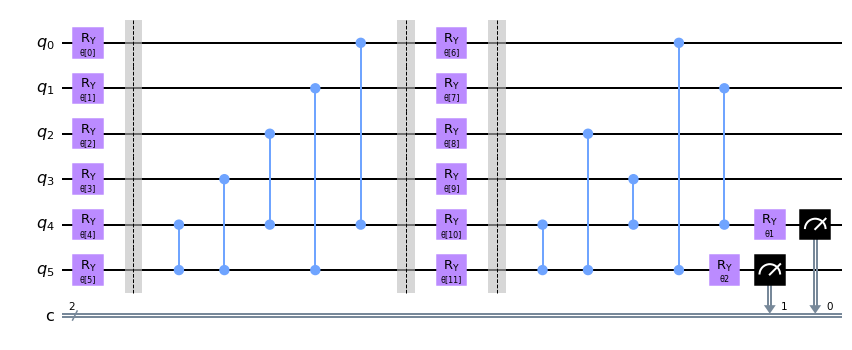

In [364]:
circ = prepare_circuit()
circ.draw('mpl') # trash qubits are at the bottom

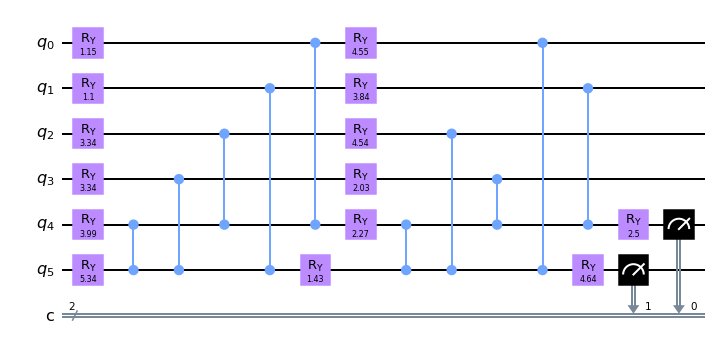

In [359]:
circ = prepare_circuit2(thetas)
# circ = prepare_circuit(feature_encoding(thetas, .6))
circ.draw('mpl') # identical to above

### Execute circuit
Circuit is executed on simulator and measurement outcomes on the trash qubits are stored

In [91]:
np.random.seed(123)

In [360]:
def run_circuit(thetas, init_state, shots=100000):
    circ = prepare_circuit2(thetas, init_state)

    # Execute the circuit on the qasm simulator.
    job_sim = execute(circ, backend_sim, shots=shots)#, seed_simulator=123, seed_transpiler=234)#, memory=True)

    # Grab the results from the job
    result_sim = job_sim.result()

    counts = result_sim.get_counts(circ)
#     print(counts)
    
#     mems = result_sim.get_memory(circ)
#     print(mems)
    return counts
# run_circuit(thetas, init_state)['11']
init_state, E = ising_groundstate(6, 1., 1.6)
run_circuit(thetas, init_state)

{'01': 13879, '10': 22526, '00': 47192, '11': 16403}

In [366]:
# same as above, just for checking
init_state, E = ising_groundstate(6, 1., 0.0)
circ.initialize(init_state, range(L))
# new_thetas = feature_encoding(thetas, g) # comment out when running w/o feature encoding
new_thetas = thetas
t_qc = transpile(circ, backend=backend_sim, seed_transpiler=234)
qobj = compiler.assemble(t_qc.bind_parameters(new_thetas), backend=backend_sim, seed_simulator=123, shots=100000)
result = backend_sim.run(qobj).result()
out = result.get_counts()
out

{'01': 20358, '00': 4341, '11': 27912, '10': 47389}

### Optimize circuit
Define cost function (averaged hamming distance of measurement outcomes) and minimze it using either scipy or qiskit optimizer modules (the latter is also based on scipy though).

In [367]:
def cost_function(thetas):
    """ Optimizes circuit for a range of input states (slower!!) """
    n_samples = 20 # different training states
#     gs = np.random.uniform(0.5, 1.0, n_samples) # Ising parameters to optimize for
    gs = np.linspace(0.1, 0.6, n_samples)
    shots = 1000 # Number of measurements for single training example
    cost = 0.
    for g in gs:
        init_state, _ = ising_groundstate(L, -1.0, g, 0.1)
#         new_thetas = feature_encoding(thetas, g) # comment out when running w/o feature encoding
        new_thetas = thetas
        out = run_circuit(new_thetas, init_state, shots=shots)
        cost += (out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0))
    return cost/(shots * n_samples)
cost_function(thetas)

0.79365

In [374]:
J, g, gx = -1., 2., 2. # Ising parameters for which ground state should be compressed
init_state, _ = ising_groundstate(L, J, g, gx)

def cost_function_single(thetas):
    """ Optimizes circuit for single input state """
    shots = 1000 # Number of measurements for single training example
    cost = 0.
    out = run_circuit(thetas, init_state, shots=shots)
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots
cost_function_single(thetas)

0.036

In [369]:
# this one is slower than the two above, but I wanted to keep it for now
J, g, gx = -1., 2., 2. # Ising parameters for which ground state should be compressed
init_state, _ = ising_groundstate(L, J, g, gx)
circ.initialize(init_state, range(L))
t_qc = transpile(circ, backend=backend_sim)#, seed_transpiler=234)

def cost_function_single_slow(thetas, t_qc):
    """ Optimizes circuit for single input state """
    shots = 1000 # Number of measurements for single training example
    qobj = compiler.assemble(t_qc.bind_parameters(thetas), backend=backend_sim, shots=shots)
    result = backend_sim.run(qobj).result()
    out = result.get_counts()
    cost = out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0)
    return cost/shots
cost_function_single_slow(thetas, t_qc)

1.266

In [370]:
#reset random seed
np.random.seed(123)

In [371]:
thetas = np.random.uniform(0, 2*np.pi, 2*L+2) # initial parameters without feature encoding
# thetas = np.random.uniform(0, 2*np.pi, ((2*L+2)*2)) # initial parameters with feature encoding

# counts, values = [], []
# def store_intermediate_result(eval_count, parameters, mean, std):
#     counts.append(eval_count)
#     values.append(mean)

# Initialize optimizer
optimizer = COBYLA(maxiter=500, tol=0.0001)
# optimizer = L_BFGS_B(maxfun=300, maxiter=500)#, factr=10, iprint=- 1, epsilon=1e-08)
# optimizer = SPSA(maxiter=40, c0=4.0, skip_calibration=True)#, callback=store_intermediate_result) # recommended from qiskit but terribly slow

start_time = time.time()
#ret = optimizer.optimize(num_vars=thetas.shape[0], objective_function=cost_function_old, initial_point=thetas)
# %timeit optimizer.optimize(num_vars=thetas.shape[0], objective_function=(lambda thetas: cost_function(thetas, t_qc)), initial_point=thetas)
ret = optimizer.optimize(num_vars=thetas.shape[0], objective_function=cost_function_single, initial_point=thetas)
print("Time: ", time.time()-start_time)
ret

Time:  48.423752784729004


(array([2.99708794, 0.03058243, 1.69146936, 1.89410245, 2.36350504,
        1.80678738, 4.76523149, 5.22360993, 2.91368558, 3.74102304,
        2.22698414, 4.55238286, 3.59073885, 0.34636982]),
 0.017,
 160)

In [372]:
ret

(array([2.99708794, 0.03058243, 1.69146936, 1.89410245, 2.36350504,
        1.80678738, 4.76523149, 5.22360993, 2.91368558, 3.74102304,
        2.22698414, 4.55238286, 3.59073885, 0.34636982]),
 0.017,
 160)

In [373]:
thetas = ret[0]

In [129]:
# #scipy
# result = minimize(cost_function_old, thetas, method='BFGS', options={'maxiter': 10})
# #result = minimize(cost_function_old, thetas, method='Powell', options={'maxiter': 10, 'ftol': 0.01})
# #Haven't tried the next one yet (but first qae paper used it)
# result = basinhopping(cost_function_old, thetas, niter=100, T=1.0, stepsize=0.5)


# print(result.fun) # cost function after optimization
# print(result.x) # optimized parameters

### Test circuit
Test optimized circuit on different Ising parameter values and (hopefully) observe phase transition

In [375]:
points = 10
gs = np.logspace(-2, 2, points)
gxs = np.logspace(-2, 2, points)
x,y = np.meshgrid(gs,gxs)
# gs = [1.0, 1.5, 2.0]
cost = np.zeros((points,points))
shots = 1000
for i,g in enumerate(gs):
    for j,gx in enumerate(gxs):
        init_state_test, _ = ising_groundstate(L, -1.0, g, gx)
#         new_thetas = feature_encoding(thetas, g)
        new_thetas = thetas
        out = run_circuit(new_thetas, init_state_test, shots=shots)
        cost[i,j] = (out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0))/shots

<ipython-input-376-634f9ef90f1a>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, out, cmap=cmap, norm=norm)


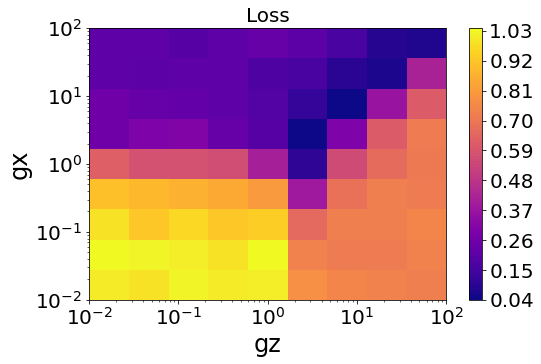

In [376]:
cmap = plt.get_cmap("plasma") #'viridis'
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
out = cost
nbins=100

ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(out.min(),out.max()) #out.max()
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, out, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel("gz",fontsize=24)
ax.set_ylabel("gx",fontsize=24)
ax.tick_params(labelsize=20)
#ax.set_ylim(*ylim)



<ipython-input-280-c2b27735430b>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, out, cmap=cmap, norm=norm)


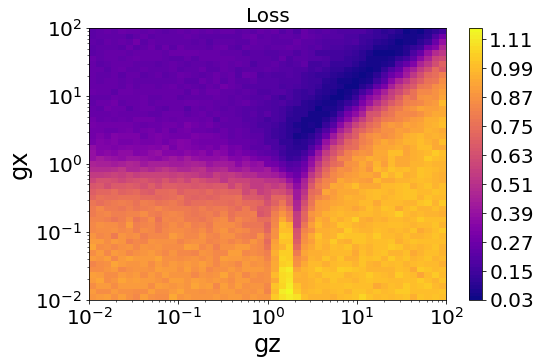

In [280]:
import matplotlib.patches as patches
from matplotlib.ticker import MaxNLocator
from matplotlib.colors import BoundaryNorm
cmap = plt.get_cmap("plasma") #'viridis'
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
out = cost
nbins=100

ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(out.min(),out.max()) #out.max()
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, out, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel("gz",fontsize=24)
ax.set_ylabel("gx",fontsize=24)
ax.tick_params(labelsize=20)
#ax.set_ylim(*ylim)



<ipython-input-262-c2b27735430b>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, out, cmap=cmap, norm=norm)


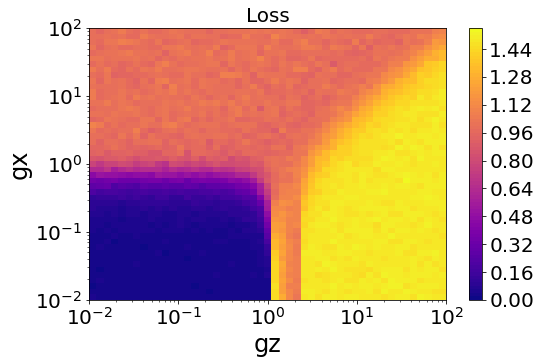

In [262]:
cmap = plt.get_cmap("plasma") #'viridis'
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
out = cost
nbins=100

ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(out.min(),out.max()) #out.max()
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, out, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel("gz",fontsize=24)
ax.set_ylabel("gx",fontsize=24)
ax.tick_params(labelsize=20)
#ax.set_ylim(*ylim)



<ipython-input-239-4ceb50f2b3a1>:12: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = ax.pcolormesh(x, y, out, cmap=cmap, norm=norm)


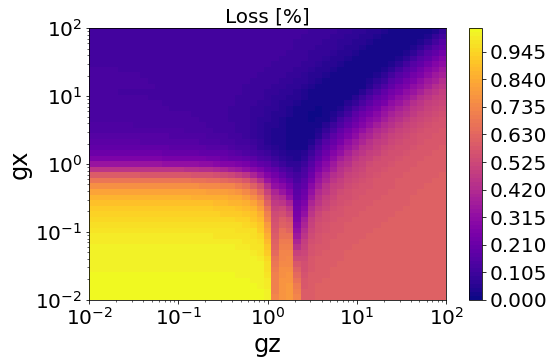

In [239]:
cmap = plt.get_cmap("plasma") #'viridis'
fig,axs = plt.subplots(figsize=(8,5),squeeze=False)
out = cost
nbins=100

ax = axs[0,0]
levels = MaxNLocator(nbins=nbins).tick_values(out.min(),out.max()) #out.max()
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)
im = ax.pcolormesh(x, y, out, cmap=cmap, norm=norm)
cbar = fig.colorbar(im, ax=ax)
cbar.ax.tick_params(labelsize=20)
plt.xscale("log")
plt.yscale("log")
ax.set_title("Loss",fontsize=20)
ax.set_xlabel("gz",fontsize=24)
ax.set_ylabel("gx",fontsize=24)
ax.tick_params(labelsize=20)
#ax.set_ylim(*ylim)



In [285]:
gs = np.logspace(-2, 2, 50)
# gs = [1.0, 1.5, 2.0]
cost = []
shots = 10000
for g in gs:
    init_state_test, _ = ising_groundstate(L, -1.0, g)
#     new_thetas = feature_encoding(thetas, g)
    new_thetas = thetas
    out = run_circuit(new_thetas, init_state_test, shots=shots)
    cost.append((out.get('11', 0)*2 + out.get('01', 0) + out.get('10', 0))/shots)

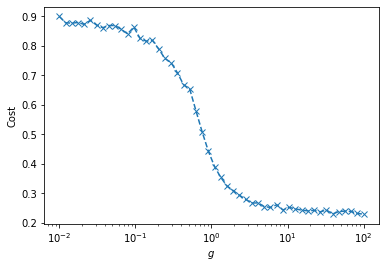

In [286]:
plt.plot(gs, cost, "x--")
plt.xscale("log")
plt.xlabel(r"$g$")
plt.ylabel("Cost");

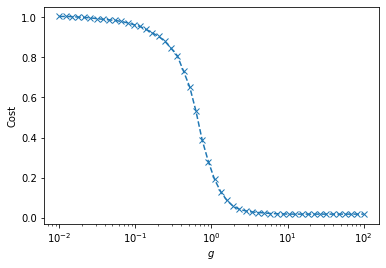

In [216]:
plt.plot(gs, cost, "x--")
plt.xscale("log")
plt.xlabel(r"$g$")
plt.ylabel("Cost");

### Reproduce results from https://arxiv.org/pdf/2010.06599.pdf

In [315]:
circ = prepare_circuit2(thetas, measurement=False)
# circ = prepare_circuit(feature_encoding(thetas, 0.6), measurement=False)

J, g, gx = -1., 2., 2.
init_state, _ = ising_groundstate(L, J, g, gx)
state = Statevector(init_state)
state = state.evolve(circ)
traced_state = qiskit.quantum_info.partial_trace(state,range(0,4))

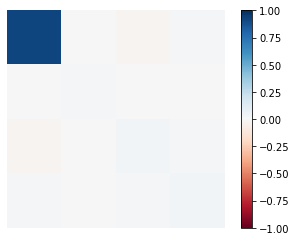

In [215]:
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');
# upper left corner corresponds to |00><00|

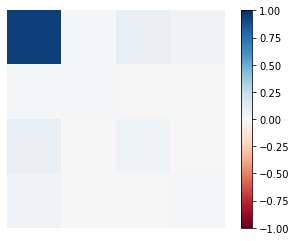

In [282]:
plt.imshow(np.real(traced_state.data), cmap='RdBu', vmin=-1.0, vmax=1.0, interpolation='none')
plt.colorbar()
plt.axis('off');
# upper left corner corresponds to |00><00|

In [346]:
cq = prepare_circuit2(thetas, measurement=False)
cq_dagger = cq.inverse()

J, g, gx = -1., 2., 2.
init_state, _ = ising_groundstate(L, J, g, gx)
state = Statevector(init_state)
state = state.evolve(cq)
traced_state = qiskit.quantum_info.partial_trace(state,[4,5])

ancilla = np.zeros(4)
ancilla[0] = 1
ancilla = qiskit.quantum_info.DensityMatrix(ancilla)
# new_state = ancilla.expand(traced_state)
new_state = traced_state.expand(ancilla)
new_state = new_state.evolve(cq_dagger)

qiskit.quantum_info.state_fidelity(Statevector(init_state), new_state)

0.883493519900475

### Fidelity

In [351]:
cq = prepare_circuit2(thetas, measurement=False)
cq_dagger = cq.inverse()

J, g, gx = -1., 2., 0.

gs = np.logspace(-2, 2, 50)
# gs = [1.0, 1.5, 2.0]
fid = []
for g in gs:
    init_state, _ = ising_groundstate(L, J, g, gx)
    state = Statevector(init_state)
    state = state.evolve(cq)
    traced_state = qiskit.quantum_info.partial_trace(state,[4,5])

    ancilla = np.zeros(4)
    ancilla[0] = 1
    ancilla = qiskit.quantum_info.DensityMatrix(ancilla)
    # new_state = ancilla.expand(traced_state)
    new_state = traced_state.expand(ancilla)
    new_state = new_state.evolve(cq_dagger)

    fid.append(qiskit.quantum_info.state_fidelity(Statevector(init_state), new_state))

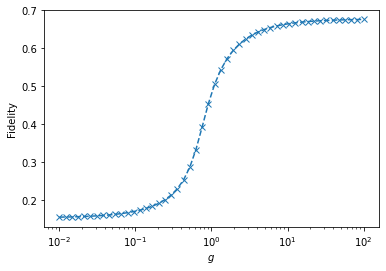

In [352]:
plt.plot(gs, fid, "x--")
plt.xscale("log")
plt.xlabel(r"$g$")
plt.ylabel("Fidelity");